In [159]:
import numpy as np
import pandas as pd
import os
import torch
import tensorflow as tf
import matplotlib.pyplot as plt
import mne
%matplotlib inline


In [145]:
# Set seed for reproducibility
np.random.seed(1000)
tf.random.set_seed(1000)

In [146]:
channels = [
    'EEG FP1-REF',
    'EEG FP2-REF',
    'EEG F3-REF',
    'EEG F4-REF',
    'EEG F7-REF',
    'EEG F8-REF',
    'EEG FZ-REF',
    'EEG A1-REF',
    'EEG A2-REF',
    'EEG T3-REF',
    'EEG T4-REF',
    'EEG C3-REF',
    'EEG C4-REF',
    'EEG CZ-REF',
    'EEG P3-REF',
    'EEG P4-REF',
    'EEG PZ-REF',
    'EEG T5-REF',
    'EEG T6-REF',
    'EEG O1-REF',
    'EEG O2-REF',
]

In [147]:
# Load the dataset
data_path = "train/normal"
os.listdir(data_path)
raw = mne.io.read_raw_edf(os.path.join(data_path, os.listdir(data_path)[0]))
raw = raw.copy().pick_channels(channels)

Extracting EDF parameters from /home/athar/Files/TUKL_work/TUH EEG Corpus/edf/train/normal/aaaaaixg_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_4750/1943758772.py:5: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw = raw.copy().pick_channels(channels)


In [148]:
raw = raw.copy().resample(100)

In [149]:
raw = raw.copy().crop(tmin=60, tmax=60*7)

In [150]:
raw

Measurement date,"April 12, 2012 13:26:05 GMT"
Experimenter,Unknown
Participant,aaaaaixg
Digitized points,Not available
Good channels,21 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,100.00 Hz
Highpass,0.00 Hz
Lowpass,50.00 Hz


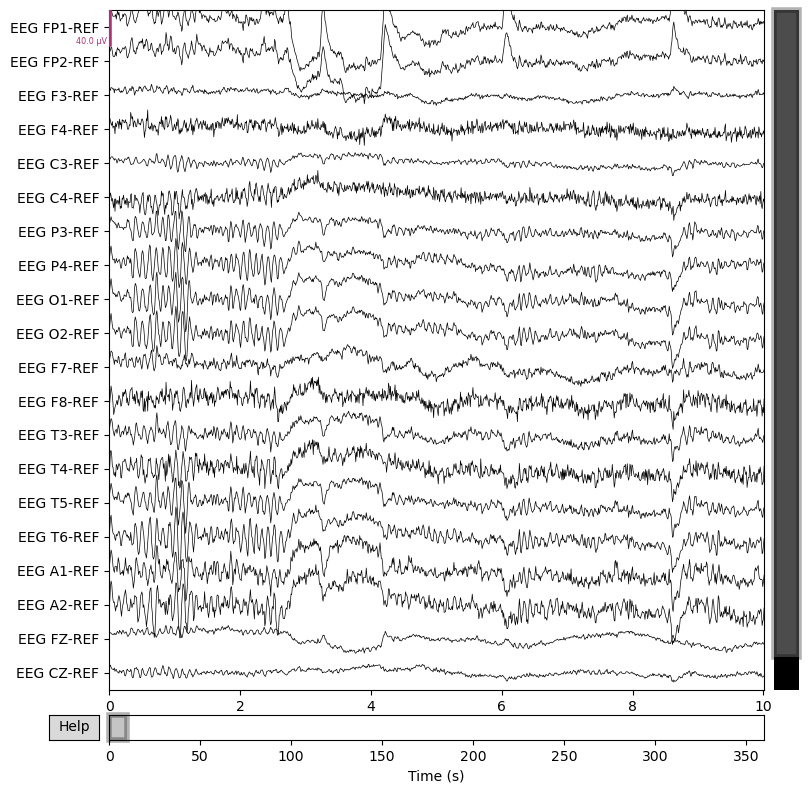

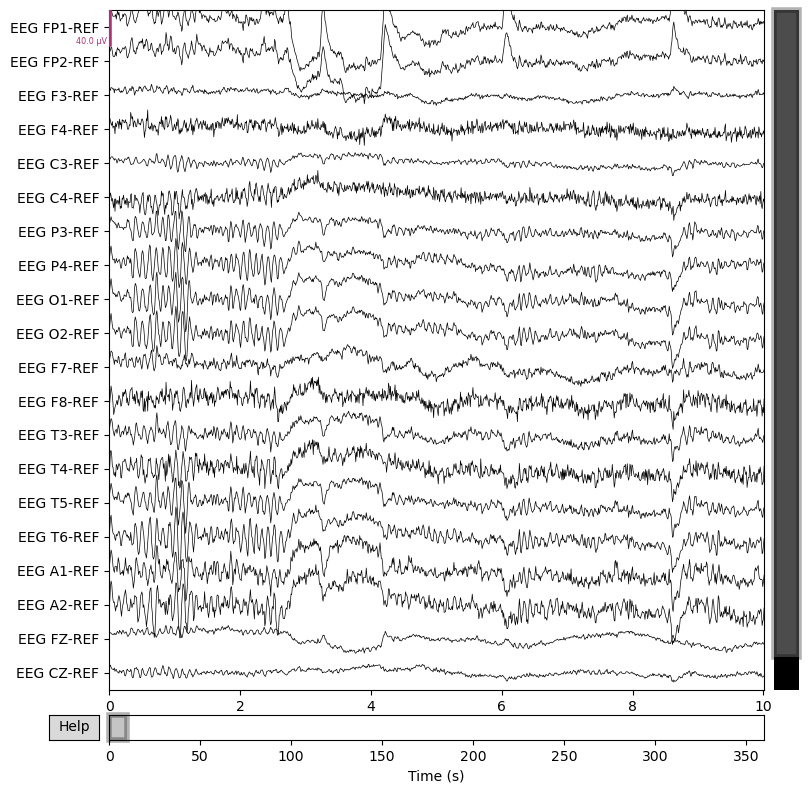

In [151]:
raw.plot()

In [289]:
x_train = raw.get_data()

In [290]:
x_train = tf.expand_dims(tf.transpose(x_train), axis = 0)

In [291]:
x_train.shape

TensorShape([1, 36001, 21])

In [307]:
# Create an SCNet model using tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPool1D, Flatten, Dense, Dropout, BatchNormalization, AvgPool1D, ReLU, Softmax
from tensorflow.keras.layers import GlobalMaxPool1D, GlobalAvgPool1D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

def mffm_block(input):
    # Convolutional layer with ReLU activation
    x1 = Conv1D(filters=8, kernel_size=5, padding='same')(input)
    x1 = BatchNormalization()(x1)
    x1 = ReLU()(x1)

    # Concatenate input and x1 along the channel axis
    x2 = Concatenate(axis=-1)([input, x1])
    x2 = Conv1D(filters=16, kernel_size=5, padding='same')(x2)
    x2 = BatchNormalization()(x2)
    x2 = ReLU()(x2)

    # Concatenate input, x1, and x2 along the channel axis
    x3 = Concatenate(axis=-1)([input, x1, x2])
    return x3


def scnet(input_shape):
    input = Input(shape=input_shape)
    # Implementing SILM
    gap = GlobalAvgPool1D(data_format='channels_first',keepdims=True)(input)
    gmp = GlobalMaxPool1D(data_format='channels_first',keepdims=True)(input)
    gsp = tf.expand_dims(tf.sqrt(tf.reduce_sum((input - gap) ** 2, axis=2)) / 21, 2)
    # Apply dropout on each
    gap = Dropout(0.05)(gap)
    gmp = Dropout(0.05)(gmp)
    gsp = Dropout(0.05)(gsp)
    # Concatenate with input
    x = Concatenate(axis=2)([input, gap, gmp, gsp])

    # Take avg and maxpool
    x1 = MaxPool1D(3, strides = 3)(x)
    x2 = AvgPool1D(3, strides = 3)(x)
    x = Concatenate(axis=1)([x1, x2])
    x = BatchNormalization()(x)
    
    x1 = mffm_block(x)
    x2 = mffm_block(x)
    x = x1 + x2
    
    # Apply spatial dropout
    x = Dropout(0.5)(x)
    x = MaxPool1D(2, strides = 2)(x)
    x = Conv1D(32, 3)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x1 = mffm_block(x)
    x2 = mffm_block(x)
    x = x1 + x2

    x = Conv1D(32, 3)(x)
    x = BatchNormalization()(x)
    x = mffm_block(x)
    x = MaxPool1D(2, strides = 2)(x)
    x = Conv1D(32, 3)(x)
    x = BatchNormalization()(x)

    # Apply gap
    x = GlobalAvgPool1D(data_format='channels_first',keepdims=True)(x)

    # Flatten the output
    x = Flatten()(x)
    x = Dense(2)(x)

    # Apply softmax
    outputs = Softmax()(x)
    return Model(inputs=input, outputs=outputs)


model = scnet((36001, 21))

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [308]:
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_72 (InputLayer)       [(None, 36001, 21)]          0         []                            
                                                                                                  
 global_average_pooling1d_6  (None, 36001, 1)             0         ['input_72[0][0]']            
 6 (GlobalAveragePooling1D)                                                                       
                                                                                                  
 tf.math.subtract_66 (TFOpL  (None, 36001, 21)            0         ['input_72[0][0]',            
 ambda)                                                              'global_average_pooling1d_66[
                                                                    0][0]']                

In [309]:
y_train = np.array([0])
y_train = tf.one_hot(y_train, 2)

In [310]:
model.fit(x_train, y_train, epochs=10)

Epoch 1/10


1/1 [==============================] - 5s 5s/step - loss: 0.6331 - accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 298ms/step - loss: 0.5046 - accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 284ms/step - loss: 0.2739 - accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 283ms/step - loss: 0.1614 - accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 249ms/step - loss: 0.0181 - accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 234ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 262ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 0s 456ms/step - loss: 2.5531e-04 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 0s 320ms/step - loss: 6.4729e-05 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 0s 337ms/step - loss: 1.5736e-05 - accuracy: 1.0000
